__Aim:__ Consistency analysis across cell lines using pathway enrichment results to find commonly up/down regulated pathways and their genes. 

__tools__:
- https://github.com/goodarzilab/iPAGE
- https://github.com/goodarzilab/pypage
- https://github.com/abearab/pager

__other tools__:
- https://github.com/tanghaibao/goatools
- https://github.com/MaayanLab/blitzgsea
- https://gseapy.readthedocs.io/en/latest/index.html

___
<!-- source: https://www.nature.com/articles/s41586-021-03313-9/figures/9

I want something like module g

<img src="https://media.springernature.com/full/springer-static/esm/art%3A10.1038%2Fs41586-021-03313-9/MediaObjects/41586_2021_3313_Fig9_ESM.jpg?as=webp" width=600 >  -->

In [1]:
!mkdir -p page

In [2]:
import re
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

sys.path.append('/data_gilbert/home/aarab/tools/pager/')

import upsetplot as us
import pager
from matplotlib.backends.backend_pdf import PdfPages

from IPython.display import IFrame

In [3]:
import pypage

In [4]:
pagerdir='/data_gilbert/home/aarab/tools/pager'

In [5]:
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])

In [6]:
from pypage import ExpressionProfile
from pypage import GeneSets
from pypage import PAGE

In [7]:
import pickle

def write_adata_pkl(data, name):
    file_name = f'{name}.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)
        print(f'Object successfully saved to "{file_name}"')


def read_adata_pkl(name):
    file_name = f'{name}.pkl'
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data

In [8]:
def load_annotation(ann_file):
    gs_ann = GeneSets(ann_file=ann_file, n_bins=3)
    return gs_ann


def load_expression(expression_file):
    df = pd.read_csv(expression_file,
                     sep="\t",
                     header=0,
                     names=["gene", "exp"])
    exp = ExpressionProfile(df.iloc[:, 0],
                            df.iloc[:, 1],
                            n_bins=10)
    # exp.convert_from_to('refseq', 'ensg', 'human')
    return exp


def run_pyPAGE(expression, annotation,threads=18):
    p = PAGE(
        expression,
        annotation,
        n_shuffle=1000,
        n_jobs=threads,
        # Hani: _"You must redo iPAGE with `--independence=0` option for comparing results between multiple smaples."_        
        filter_redundant=False
    )
    
    _,_ = p.run()
    
    return p

### Load genesets

In [9]:
# msigdb_c5_go = load_annotation(f'{pagerdir}/annotations/human/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt')
# msigdb_c5_go._calculate_pathway_sizes()

In [10]:
# pd.Series(msigdb_c5_go.pathway_sizes).plot.hist(bins=200)
# plt.axvline(10, color='k', linestyle='dashed', linewidth=1)
# plt.axvline(500, color='k', linestyle='dashed', linewidth=1)

# plt.yscale('log')
# plt.show()

In [11]:
# msigdb_c5_go.filter_pathways(min_size=10,max_size=500)

In [12]:
# msigdb_c2_kegg = load_annotation(f'{pagerdir}/annotations/human/msigdb_v7.4_c2.cp.kegg/c2.cp.kegg.v7.4.symbols.gmt')

msigdb_c5_gobp = load_annotation(f'{pagerdir}/annotations/human/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt')
# msigdb_c5_gobp._calculate_pathway_sizes()

# msigdb_c5_gobp.filter_pathways(min_size=50,max_size=150)

## run pyPAGE

In [13]:
counts = pd.read_csv('deseq2_norm.txt',sep='\t')

### $\Delta$Expression

In [30]:
exp_results = {}

for delta_exp in glob('exp/*delta_exp.txt'):
    msigdb_c5_gobp.modified = False   # https://github.com/goodarzilab/pypage/issues/47#issuecomment-1699760555 
    name = delta_exp.split('/')[1].replace('_delta_exp.txt','')
    print(name)
    exp_results[name] = run_pyPAGE(load_expression(delta_exp),msigdb_c5_gobp)
    print()

comb_vs_dmso


permutation testing:   5%|▌         | 402/7481 [02:11<38:37,  3.06it/s]
hypergeometric tests: 370it [00:01, 230.96it/s]



comb_vs_decitabine


permutation testing:   8%|▊         | 580/7481 [03:04<36:30,  3.15it/s]
hypergeometric tests: 388it [00:01, 302.67it/s]

In [32]:
write_adata_pkl(exp_results,'page/exp_results_msigdb_c5_gobp')

Object successfully saved to "page/exp_results_msigdb_c5_gobp.pkl"


In [14]:
exp_results = read_adata_pkl('page/exp_results_msigdb_c5_gobp')

## Draw heatmaps
Fig. S3E

In [15]:
def subset_results(p):
    return pd.concat([
        pager.pvmat2bio_signal(
            p.get_es_matrix(),
            side=s,n_clust=n,
            thr = -np.log10(0.05)
        ) for s,n in zip(['up','down'],[1,2,3])
    ])


def draw_heatmap(es_matrix,cmap = 'viridis'):
    # https://github.com/goodarzilab/pypage/issues/46
    return pypage.heatmap.Heatmap(pathways=es_matrix.index,graphical_ar=es_matrix.to_numpy(),cmap_main = cmap)

In [16]:
modality = "RNA Expression"

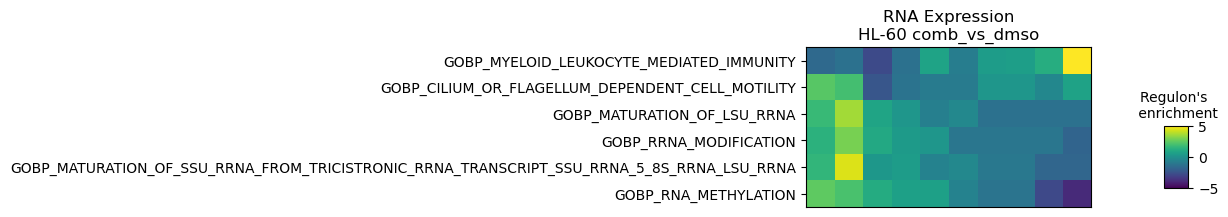

In [31]:
draw_heatmap(
    subset_results(exp_results['comb_vs_dmso'])
).show(title=f'{modality}\nHL-60 comb_vs_dmso')

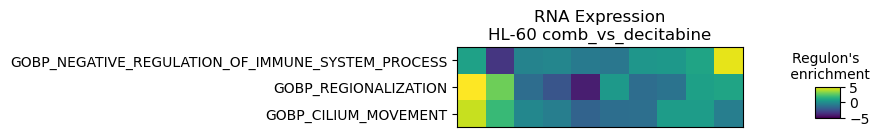

In [33]:
draw_heatmap(
    subset_results(exp_results['comb_vs_decitabine'])
).show(title=f'{modality}\nHL-60 comb_vs_decitabine')

In [34]:
subset_results(exp_results['comb_vs_decitabine'])

,0,1,2,3,4,5,6,7,8,9
GOBP_NEGATIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS,0.718778,-3.432921,-0.509812,-0.414212,-0.876665,-1.036669,0.270373,0.337547,0.845197,4.645526
GOBP_REGIONALIZATION,6.292680,2.805761,-1.440917,-2.346056,-4.174273,0.362626,-1.437324,-1.205142,0.703120,0.846052
GOBP_CILIUM_MOVEMENT,4.168642,1.754759,-0.362701,-0.737956,-1.812077,-1.367607,-1.365380,0.522764,0.524126,-0.737956


In [35]:
'","'.join(
    [gene for genes in exp_results['comb_vs_decitabine'].get_enriched_genes(
        'GOBP_NEGATIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS')[-1:] for gene in genes]
)

'ANXA1","BCL6","C5AR2","CCL3","CD22","CD300A","CD55","CD86","CEBPB","CRTAM","DHX58","DLG5","DUSP1","FCGR2B","FCRLB","FGL2","FGR","GBP1","GPR137","GPR137B","HMOX1","IFI16","IL12B","IL1RL1","IL20RB","IL2RA","IL4R","KIR2DL4","KITLG","LGALS3","LILRB2","LILRB3","LRRC17","MAFB","MERTK","NOD2","PAG1","PAWR","PLCL2","PTPN22","PTPRJ","RIN3","RIPOR2","SDC4","SFTPD","SYT11","THBS1","TNF","TNFRSF14","TRIB1","VSIR","ZC3H12A'

___
# 

In [36]:
!date

Mon Sep  4 03:56:17 PDT 2023
